In [1]:
import logging
for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(format='[%(levelname)s] %(asctime)s:\t %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.INFO)

In [2]:
import sys

if 'almop' not in ' '.join(sys.path):
    logging.info('Local module \'almop\' not found in system path. Appending...')
    sys.path.append('../almop')

[INFO] 2023-04-22 21:36:44,958:	 Local module 'almop' not found in system path. Appending...


In [3]:
import almop as al
import eurostat as es
import pandas as pd

In [4]:
# Downloading House Price Index data
hpi_raw = es.get_data_df('PRC_HPI_Q')

In [68]:
hpi = hpi_raw.copy()   # Create another variable to prevent writing to `hpi_raw` on accident. 
hpi = hpi.loc[hpi['geo\TIME_PERIOD'].isin( ['PL', 'DE', 'IT', 'BE', 'SE']) ]
hpi = hpi.loc[hpi['unit'] == 'RCH_Q']
hpi = hpi.loc[hpi['purchase'] == 'TOTAL']
hpi.head()

,freq,purchase,unit,geo\TIME_PERIOD,2005-Q1,2005-Q2,2005-Q3,2005-Q4,2006-Q1,2006-Q2,...,2020-Q3,2020-Q4,2021-Q1,2021-Q2,2021-Q3,2021-Q4,2022-Q1,2022-Q2,2022-Q3,2022-Q4
345,Q,TOTAL,RCH_Q,BE,NaN,2.2,3.6,2.0,1.9,2.7,...,2.2,2.2,1.0,1.8,3.0,0.1,1.4,1.3,2.4,-0.4
350,Q,TOTAL,RCH_Q,DE,NaN,-1.8,2.1,-2.8,1.5,0.4,...,3.0,2.9,1.4,3.8,4.2,2.7,0.4,2.1,-1.0,-5.0
366,Q,TOTAL,RCH_Q,IT,NaN,NaN,NaN,NaN,NaN,NaN,...,-2.5,0.2,1.1,1.7,1.1,0.1,1.6,2.3,-1.1,0.0
373,Q,TOTAL,RCH_Q,PL,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,1.0,2.0,3.1,2.6,3.9,3.3,2.0,2.4,1.4
376,Q,TOTAL,RCH_Q,SE,NaN,3.3,3.9,2.6,3.5,2.9,...,2.2,1.7,3.1,3.5,2.6,1.3,2.6,0.5,-3.1,-3.6


In [69]:
hpi = hpi.iloc[:,3:]
hpi = hpi.rename(columns={hpi.columns[0] : 'country'})
hpi = hpi.set_index('country', drop=True).T
hpi.head()

country,BE,DE,IT,PL,SE
2005-Q1,NaN,NaN,NaN,NaN,NaN
2005-Q2,2.2,-1.8,NaN,NaN,3.3
2005-Q3,3.6,2.1,NaN,NaN,3.9
2005-Q4,2.0,-2.8,NaN,NaN,2.6
2006-Q1,1.9,1.5,NaN,NaN,3.5


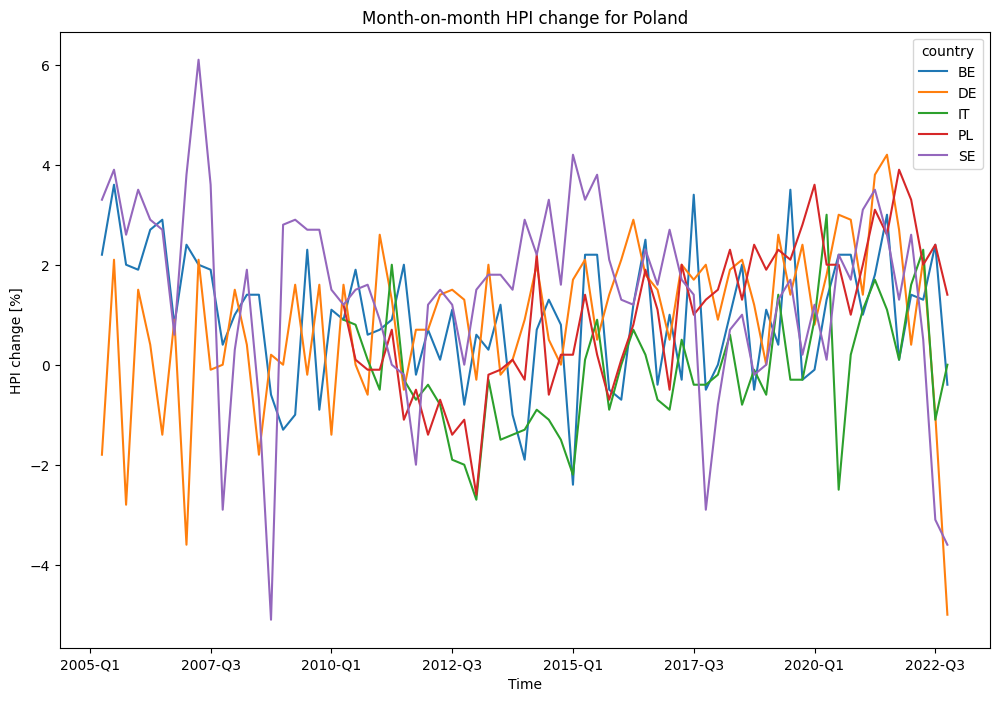

In [70]:
_ = hpi.plot(xlabel='Time', ylabel='HPI change [%]', title='Month-on-month HPI change for Poland', figsize=(12, 8), legend=True )